# Propuesta

## Modelo Solo simulado

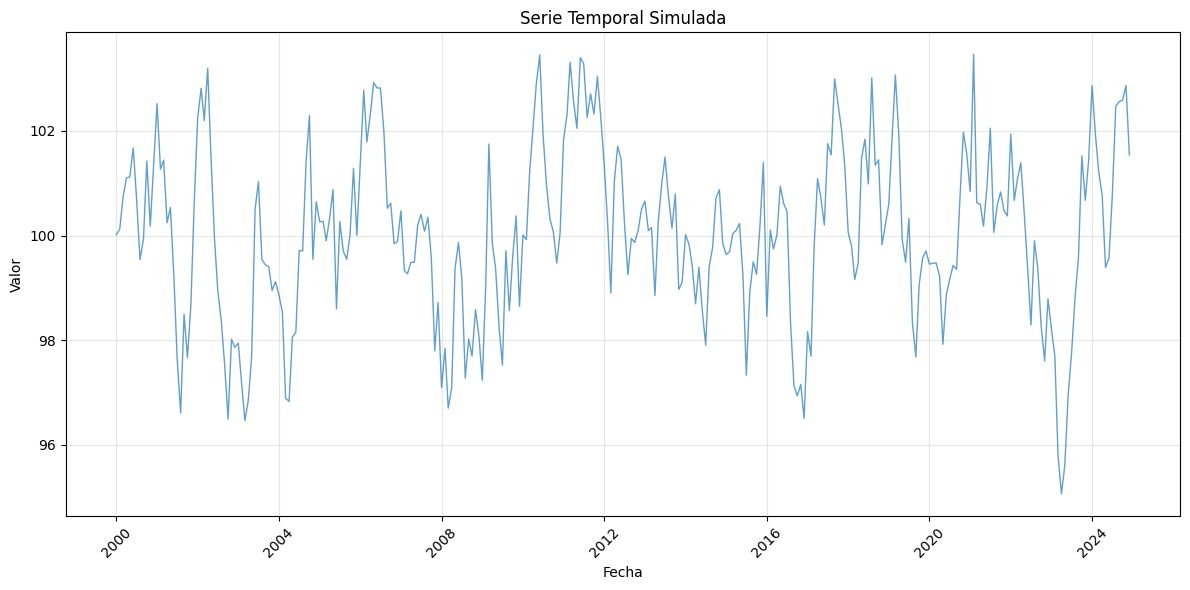

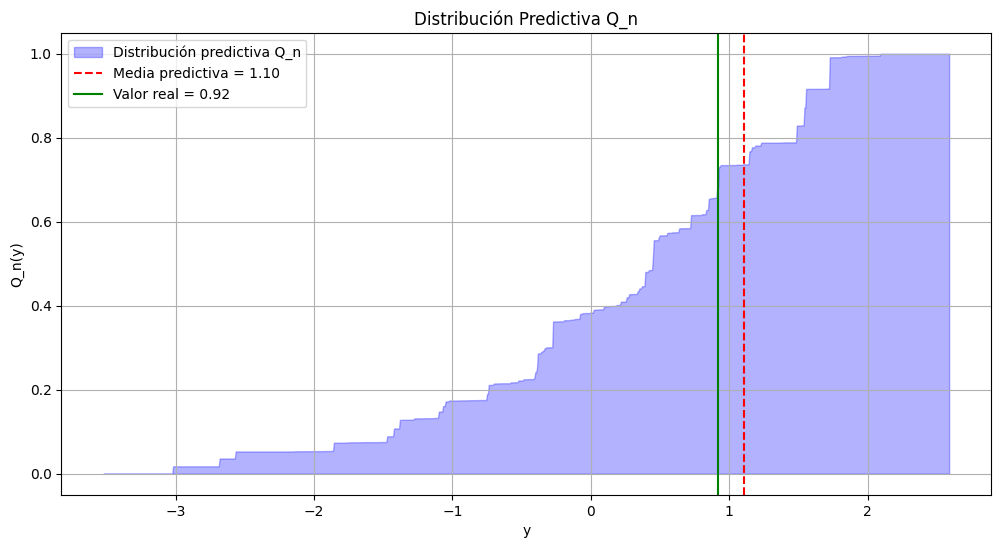

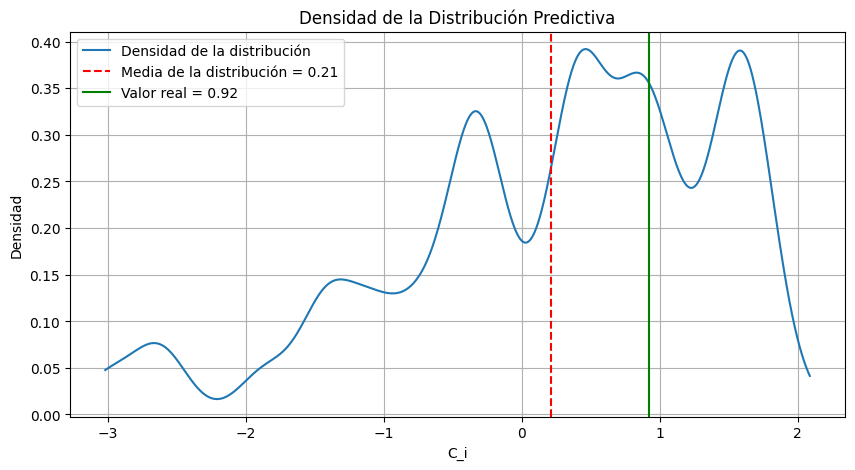

CRPS: 0.3683


In [4]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.linalg import solve
from scipy.stats import gaussian_kde
from properscoring import crps_ensemble
from numba import jit
import warnings
from statsmodels.tsa.arima_process import ArmaProcess

warnings.filterwarnings('ignore')

def prepare_data(df):
    values = df['valor'].values
    mean_val = np.mean(values)
    std_val = np.std(values)
    normalized_values = (values - mean_val) / std_val

    X = np.ones((len(normalized_values), 1))  # Solo intercepto
    y = normalized_values

    return X, y, mean_val, std_val

@jit(nopython=True)
def fast_hat_matrix(X):
    XtX = X.T @ X
    XtX_inv = np.linalg.inv(XtX)
    return X @ XtX_inv @ X.T

def calculate_C_values_optimized(X, y, x_test):
    n = len(y)
    X_bar = np.vstack((X, x_test))
    H_bar = fast_hat_matrix(X_bar)
    H = H_bar[:-1, :-1]
    h = H_bar[-1, :-1]

    I_minus_H_inv = solve(np.eye(n) - H, np.eye(n))
    y_minus_Hy = y - H @ y
    h_i_star = H - np.outer(np.ones(n), h)

    C = y + (h_i_star @ I_minus_H_inv) @ y_minus_Hy

    return C

def plot_predictive_distribution(C, y_real, num_points=1000):
    C_sorted = np.sort(C)
    y_range = np.linspace(C_sorted[0] - 0.5, C_sorted[-1] + 0.5, num_points)
    intervals = np.array([[max(0, np.sum(C_sorted <= y)/len(C_sorted) - 1), min(1, np.sum(C_sorted <= y)/len(C_sorted))] for y in y_range])

    lower_bounds, upper_bounds = intervals[:, 0], intervals[:, 1]
    mean_pred = (lower_bounds + upper_bounds) / 2
    weighted_mean = np.sum(y_range * mean_pred) / np.sum(mean_pred)

    plt.figure(figsize=(12, 6))
    plt.fill_between(y_range, lower_bounds, upper_bounds, alpha=0.3, color='blue', label='Distribución predictiva Q_n')
    plt.axvline(x=weighted_mean, color='r', linestyle='--', label=f'Media predictiva = {weighted_mean:.2f}')
    plt.axvline(x=y_real, color='g', linestyle='-', label=f'Valor real = {y_real:.2f}')
    plt.xlabel('y')
    plt.ylabel('Q_n(y)')
    plt.title('Distribución Predictiva Q_n')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_density_distribution(C, y_real):
    density = gaussian_kde(C)
    x_vals = np.linspace(min(C), max(C), 1000)
    y_vals = density(x_vals)
    mean_C = np.mean(C)

    plt.figure(figsize=(10, 5))
    plt.plot(x_vals, y_vals, label='Densidad de la distribución')
    plt.axvline(mean_C, color='r', linestyle='--', label=f'Media de la distribución = {mean_C:.2f}')
    plt.axvline(y_real, color='g', linestyle='-', label=f'Valor real = {y_real:.2f}')
    plt.xlabel('C_i')
    plt.ylabel('Densidad')
    plt.title('Densidad de la Distribución Predictiva')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_time_series(df):
    plt.figure(figsize=(12, 6))
    plt.plot(df['fecha'], df['valor'], alpha=0.7, linewidth=1)
    plt.xlabel('Fecha')
    plt.ylabel('Valor')
    plt.title('Serie Temporal Simulada')
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def apply_weights_efficient(C, rho, max_points):
    n = len(C)
    weights = rho ** np.arange(n-1, -1, -1)
    weights = weights / np.min(weights)

    scale_factor = min(max_points / np.sum(weights), 100)
    repeats = np.maximum(np.round(weights * scale_factor).astype(np.int64), 1)

    total_points = np.sum(repeats)
    result = np.zeros(total_points)

    current_idx = 0
    for i in range(n):
        result[current_idx:current_idx + repeats[i]] = C[i]
        current_idx += repeats[i]

    return result

def main():
    ar = np.array([1, -0.75])
    ma = np.array([1])
    arma_process = ArmaProcess(ar, ma)
    n_points = 300
    simulated_data = arma_process.generate_sample(nsample=n_points, scale=1) + 100
    dates = pd.date_range(start='2000-01-01', periods=n_points, freq='MS')
    df = pd.DataFrame({'fecha': dates, 'valor': simulated_data})

    plot_time_series(df)

    X, y, mean_val, std_val = prepare_data(df)
    last_value = (df['valor'].iloc[-1] - mean_val) / std_val
    x_test = np.array([[1]])  # Solo intercepto
    y_real = last_value

    C = calculate_C_values_optimized(X, y, x_test)
     # Aplicar pesos y visualizar
    C_weighted = apply_weights_efficient(C, rho=0.95, max_points=10000)
    
    plot_predictive_distribution(C_weighted, y_real)
    plot_density_distribution(C_weighted, y_real)
    
    # Calcular CRPS usando todos los valores
    C_sorted = np.sort(C_weighted)
    crps = crps_ensemble(np.array([y_real]), C_sorted.reshape(1, -1))[0]
    print(f"CRPS: {crps:.4f}")
    
    return crps

if __name__ == "__main__":
    main()

## Con rolling window

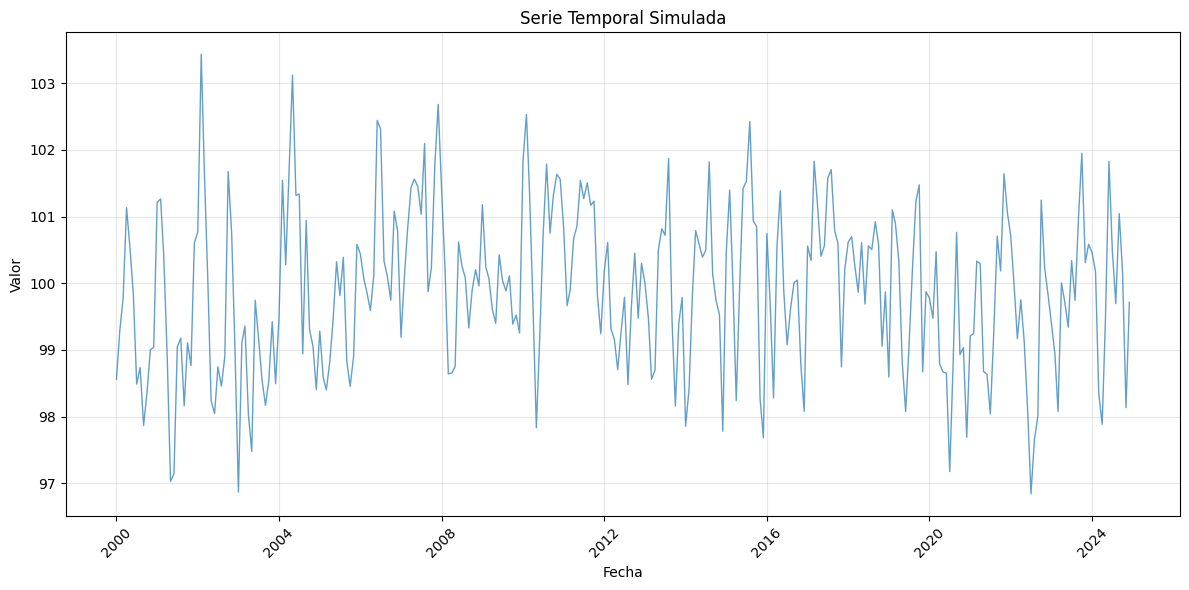

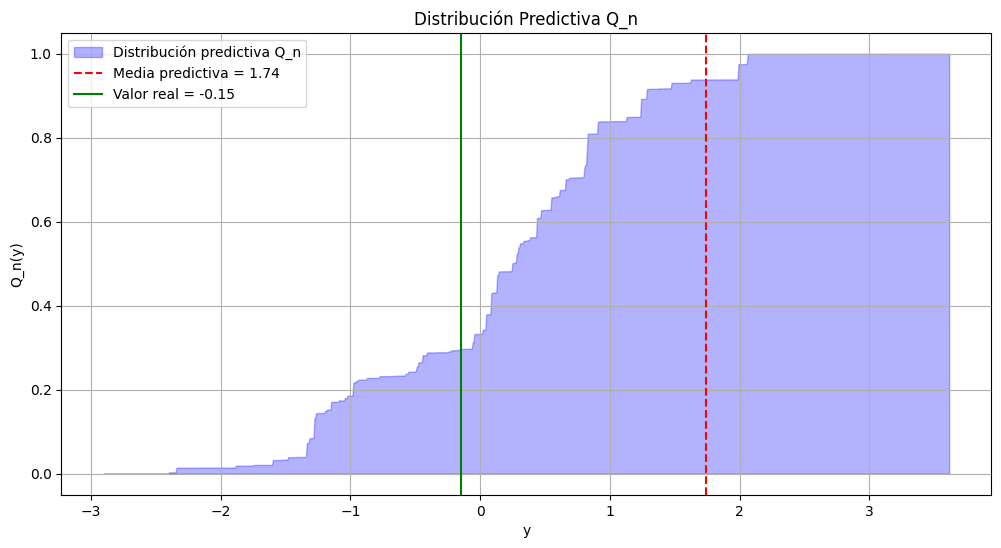

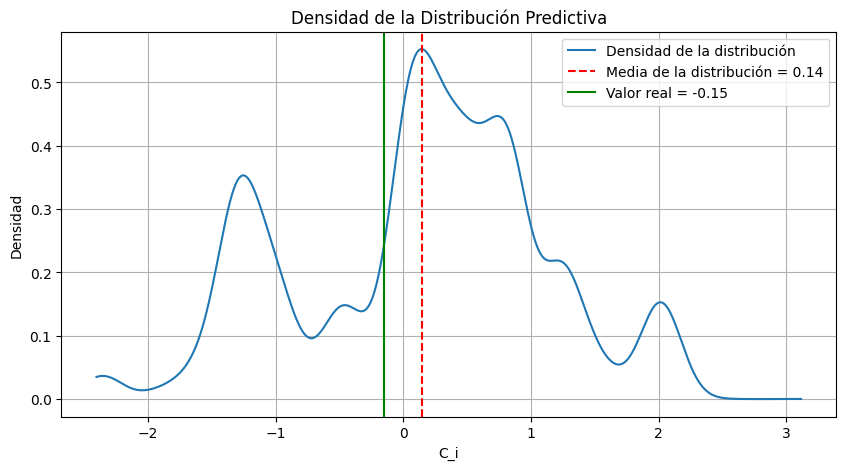

CRPS: 0.3116


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from properscoring import crps_ensemble
from statsmodels.tsa.arima_process import ArmaProcess
import warnings

warnings.filterwarnings('ignore')

def prepare_data(df):
    values = df['valor'].values
    mean_val = np.mean(values)
    std_val = np.std(values)
    normalized_values = (values - mean_val) / std_val
    
    return normalized_values, mean_val, std_val

def calculate_predictive_distribution(values, window_size=50):
    """Calculate predictive distribution using a rolling window approach"""
    n = len(values)
    all_differences = []
    
    for i in range(n - window_size):
        current_window = values[i:i+window_size]
        next_value = values[i+window_size]
        all_differences.append(next_value - np.mean(current_window))
    
    return np.array(all_differences)

def plot_predictive_distribution(C, y_real, num_points=1000):
    C_sorted = np.sort(C)
    y_range = np.linspace(C_sorted[0] - 0.5, C_sorted[-1] + 0.5, num_points)
    intervals = np.array([[max(0, np.sum(C_sorted <= y)/len(C_sorted) - 1), 
                          min(1, np.sum(C_sorted <= y)/len(C_sorted))] 
                         for y in y_range])
    
    lower_bounds, upper_bounds = intervals[:, 0], intervals[:, 1]
    mean_pred = (lower_bounds + upper_bounds) / 2
    weighted_mean = np.sum(y_range * mean_pred) / np.sum(mean_pred)
    
    plt.figure(figsize=(12, 6))
    plt.fill_between(y_range, lower_bounds, upper_bounds, 
                    alpha=0.3, color='blue', label='Distribución predictiva Q_n')
    plt.axvline(x=weighted_mean, color='r', linestyle='--', 
                label=f'Media predictiva = {weighted_mean:.2f}')
    plt.axvline(x=y_real, color='g', linestyle='-', 
                label=f'Valor real = {y_real:.2f}')
    plt.xlabel('y')
    plt.ylabel('Q_n(y)')
    plt.title('Distribución Predictiva Q_n')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_density_distribution(C, y_real):
    density = gaussian_kde(C)
    x_vals = np.linspace(min(C), max(C), 1000)
    y_vals = density(x_vals)
    mean_C = np.mean(C)
    
    plt.figure(figsize=(10, 5))
    plt.plot(x_vals, y_vals, label='Densidad de la distribución')
    plt.axvline(mean_C, color='r', linestyle='--', 
                label=f'Media de la distribución = {mean_C:.2f}')
    plt.axvline(y_real, color='g', linestyle='-', 
                label=f'Valor real = {y_real:.2f}')
    plt.xlabel('C_i')
    plt.ylabel('Densidad')
    plt.title('Densidad de la Distribución Predictiva')
    plt.legend()
    plt.grid(True)
    plt.show()
    
def plot_time_series(df):
    plt.figure(figsize=(12, 6))
    plt.plot(df['fecha'], df['valor'], alpha=0.7, linewidth=1)
    plt.xlabel('Fecha')
    plt.ylabel('Valor')
    plt.title('Serie Temporal Simulada')
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def apply_weights_efficient(C, rho, max_points):
    n = len(C)
    weights = rho ** np.arange(n-1, -1, -1)
    weights = weights / np.min(weights)
    
    scale_factor = min(max_points / np.sum(weights), 100)
    repeats = np.maximum(np.round(weights * scale_factor).astype(np.int64), 1)
    
    total_points = np.sum(repeats)
    result = np.zeros(total_points)
    
    current_idx = 0
    for i in range(n):
        result[current_idx:current_idx + repeats[i]] = C[i]
        current_idx += repeats[i]
    
    return result

def main():
    # Generar datos simulados
    ar = np.array([1, -0.5])
    ma = np.array([1])
    arma_process = ArmaProcess(ar, ma)
    n_points = 300
    simulated_data = arma_process.generate_sample(nsample=n_points, scale=1) + 100
    dates = pd.date_range(start='2000-01-01', periods=n_points, freq='MS')
    df = pd.DataFrame({'fecha': dates, 'valor': simulated_data})
    
    plot_time_series(df)
    
    # Preparar datos
    normalized_values, mean_val, std_val = prepare_data(df)
    
    # Calcular distribución predictiva
    C = calculate_predictive_distribution(normalized_values)
    y_real = normalized_values[-1]
    
     # Aplicar pesos y visualizar
    C_weighted = apply_weights_efficient(C, rho=0.95, max_points=10000)
    
    plot_predictive_distribution(C_weighted, y_real)
    plot_density_distribution(C_weighted, y_real)
    
    # Calcular CRPS usando todos los valores
    C_sorted = np.sort(C_weighted)
    crps = crps_ensemble(np.array([y_real]), C_sorted.reshape(1, -1))[0]
    print(f"CRPS: {crps:.4f}")
    
    return crps
if __name__ == "__main__":
    main()

## Con lags

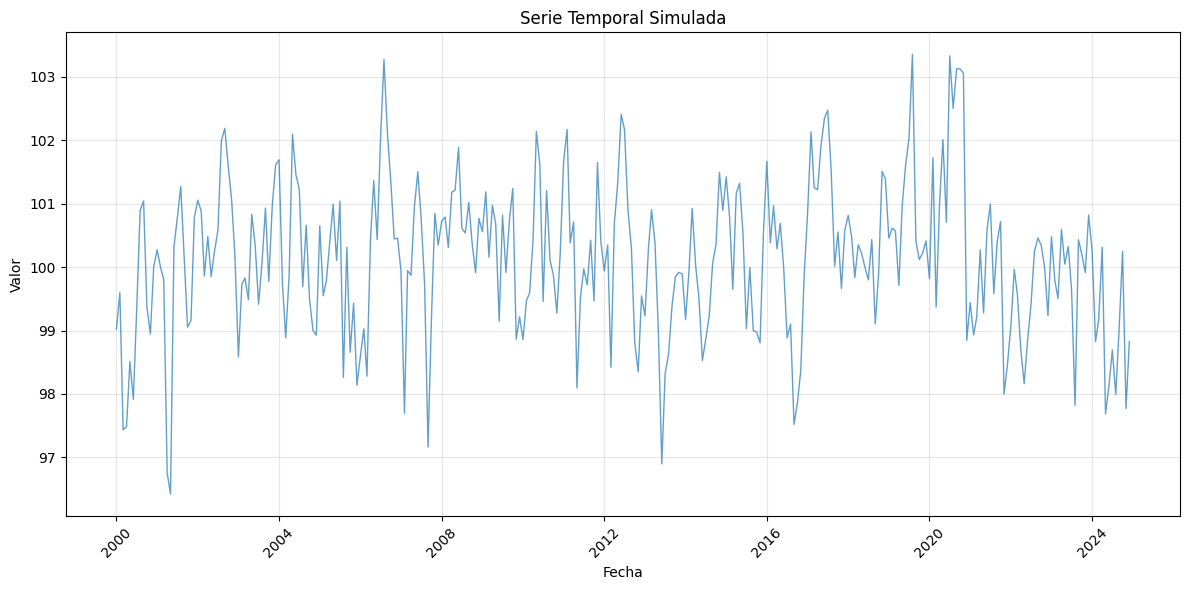

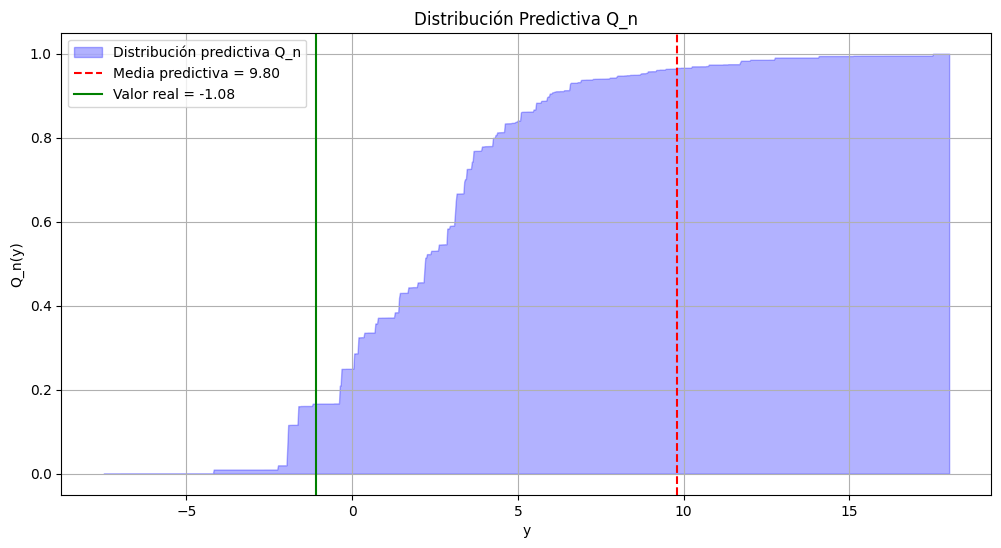

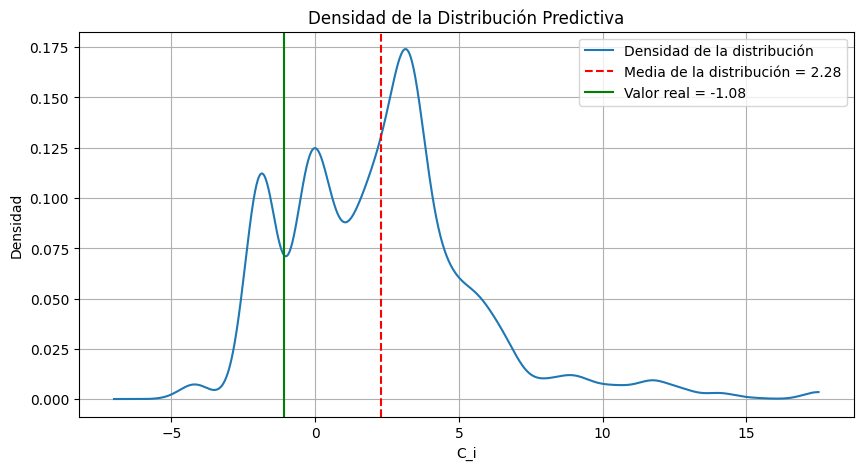

CRPS: 1.8907


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.linalg import solve
from scipy.stats import gaussian_kde
from properscoring import crps_ensemble
from numba import jit
import warnings
from statsmodels.tsa.arima_process import ArmaProcess

warnings.filterwarnings('ignore')

@jit(nopython=True)
def create_lag_matrix(values, n_lags):
    n = len(values) - n_lags
    X = np.zeros((n, n_lags + 1))
    X[:, 0] = 1  # Intercepto
    
    for lag in range(n_lags):
        X[:, lag + 1] = values[lag:lag + n]
    
    return X

def prepare_data(df, n_lags=5):
    values = df['valor'].values
    mean_val = np.mean(values)
    std_val = np.std(values)
    normalized_values = (values - mean_val) / std_val
    
    X = create_lag_matrix(normalized_values, n_lags)
    y = normalized_values[n_lags:]
    
    return X, y, mean_val, std_val

@jit(nopython=True)
def fast_hat_matrix(X):
    XtX = X.T @ X
    XtX_inv = np.linalg.inv(XtX)
    return X @ XtX_inv @ X.T

def calculate_C_values_optimized(X, y, x_test):
    n = len(y)
    X_bar = np.vstack((X, x_test))
    H_bar = fast_hat_matrix(X_bar)
    H = H_bar[:-1, :-1]
    h = H_bar[-1, :-1]
    
    I_minus_H_inv = solve(np.eye(n) - H, np.eye(n))
    y_minus_Hy = y - H @ y
    h_i_star = H - np.outer(np.ones(n), h)
    
    C = y + (h_i_star @ I_minus_H_inv) @ y_minus_Hy
    
    return C

def plot_predictive_distribution(C, y_real, num_points=1000):
    C_sorted = np.sort(C)
    y_range = np.linspace(C_sorted[0] - 0.5, C_sorted[-1] + 0.5, num_points)
    intervals = np.array([[max(0, np.sum(C_sorted <= y)/len(C_sorted) - 1), min(1, np.sum(C_sorted <= y)/len(C_sorted))] for y in y_range])
    
    lower_bounds, upper_bounds = intervals[:, 0], intervals[:, 1]
    mean_pred = (lower_bounds + upper_bounds) / 2
    weighted_mean = np.sum(y_range * mean_pred) / np.sum(mean_pred)
    
    plt.figure(figsize=(12, 6))
    plt.fill_between(y_range, lower_bounds, upper_bounds, alpha=0.3, color='blue', label='Distribución predictiva Q_n')
    plt.axvline(x=weighted_mean, color='r', linestyle='--', label=f'Media predictiva = {weighted_mean:.2f}')
    plt.axvline(x=y_real, color='g', linestyle='-', label=f'Valor real = {y_real:.2f}')
    plt.xlabel('y')
    plt.ylabel('Q_n(y)')
    plt.title('Distribución Predictiva Q_n')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_density_distribution(C, y_real):
    density = gaussian_kde(C)
    x_vals = np.linspace(min(C), max(C), 1000)
    y_vals = density(x_vals)
    mean_C = np.mean(C)
    
    plt.figure(figsize=(10, 5))
    plt.plot(x_vals, y_vals, label='Densidad de la distribución')
    plt.axvline(mean_C, color='r', linestyle='--', label=f'Media de la distribución = {mean_C:.2f}')
    plt.axvline(y_real, color='g', linestyle='-', label=f'Valor real = {y_real:.2f}')
    plt.xlabel('C_i')
    plt.ylabel('Densidad')
    plt.title('Densidad de la Distribución Predictiva')
    plt.legend()
    plt.grid(True)
    plt.show()
    
def plot_time_series(df):
    plt.figure(figsize=(12, 6))
    plt.plot(df['fecha'], df['valor'], alpha=0.7, linewidth=1)
    plt.xlabel('Fecha')
    plt.ylabel('Valor')
    plt.title('Serie Temporal Simulada')
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def apply_weights_efficient(C, rho, max_points):
    n = len(C)
    weights = rho ** np.arange(n-1, -1, -1)
    weights = weights / np.min(weights)
    
    scale_factor = min(max_points / np.sum(weights), 100)
    repeats = np.maximum(np.round(weights * scale_factor).astype(np.int64), 1)
    
    total_points = np.sum(repeats)
    result = np.zeros(total_points)
    
    current_idx = 0
    for i in range(n):
        result[current_idx:current_idx + repeats[i]] = C[i]
        current_idx += repeats[i]
    
    return result

def main():
    # Definir parámetros del modelo AR(1)
    ar = np.array([1, -0.5])  # Coeficientes AR
    ma = np.array([1])  # Coeficientes MA
    # Generar datos simulados usando un proceso AR(1)
    arma_process = ArmaProcess(ar, ma)
    n_points = 300
    simulated_data = arma_process.generate_sample(nsample=n_points, scale=1) + 100  # Media 100, desviación estándar 1
    dates = pd.date_range(start='2000-01-01', periods=n_points, freq='MS')
    df = pd.DataFrame({'fecha': dates, 'valor': simulated_data})
    
    plot_time_series(df)
    
    n_lags = 5
    X, y, mean_val, std_val = prepare_data(df, n_lags)
    last_values = (df['valor'].iloc[-n_lags-1:-1].values - mean_val) / std_val
    x_test = np.concatenate(([1], last_values[::-1]))
    y_real = (df['valor'].iloc[-1] - mean_val) / std_val
    
    C = calculate_C_values_optimized(X, y, x_test)
     # Aplicar pesos y visualizar
    C_weighted = apply_weights_efficient(C, rho=0.95, max_points=10000)
    
    plot_predictive_distribution(C_weighted, y_real)
    plot_density_distribution(C_weighted, y_real)
    
    # Calcular CRPS usando todos los valores
    C_sorted = np.sort(C_weighted)
    crps = crps_ensemble(np.array([y_real]), C_sorted.reshape(1, -1))[0]
    print(f"CRPS: {crps:.4f}")
    
    return crps

if __name__ == "__main__":
    main()

## Modelo solo Datos reales

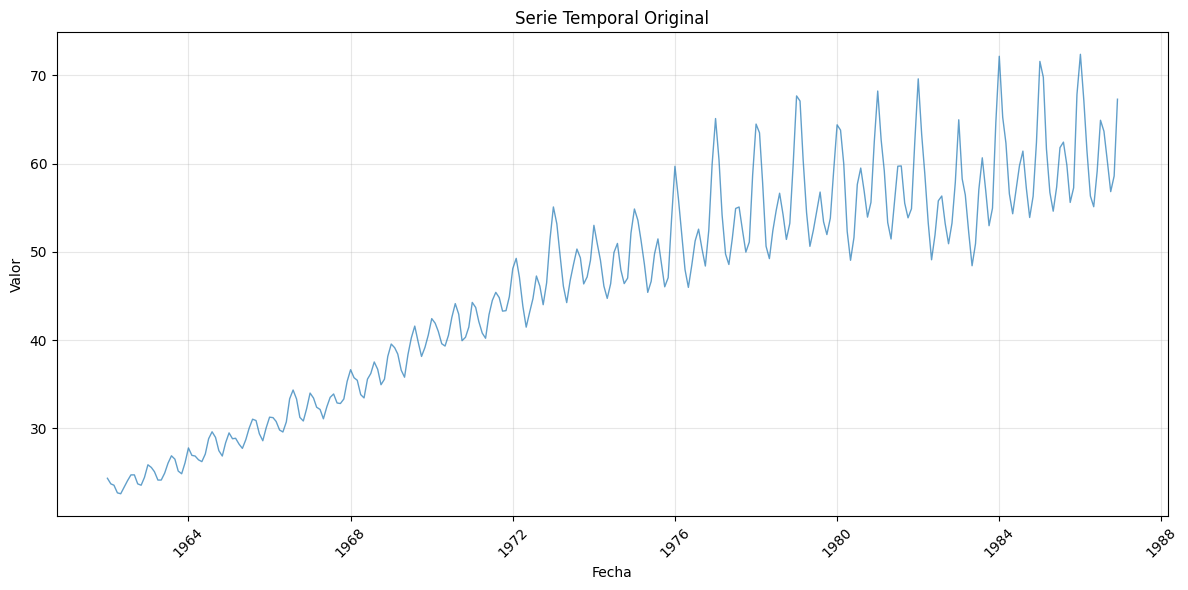

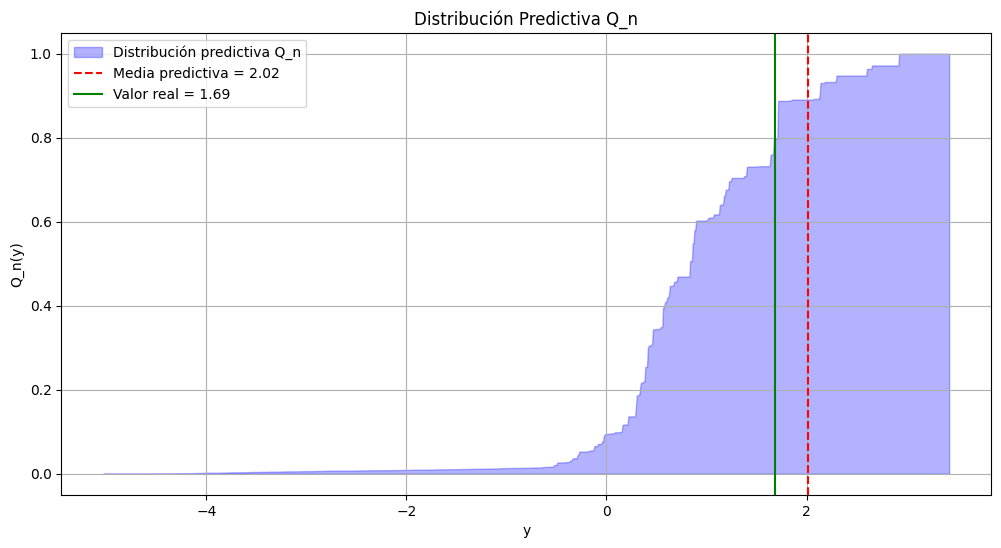

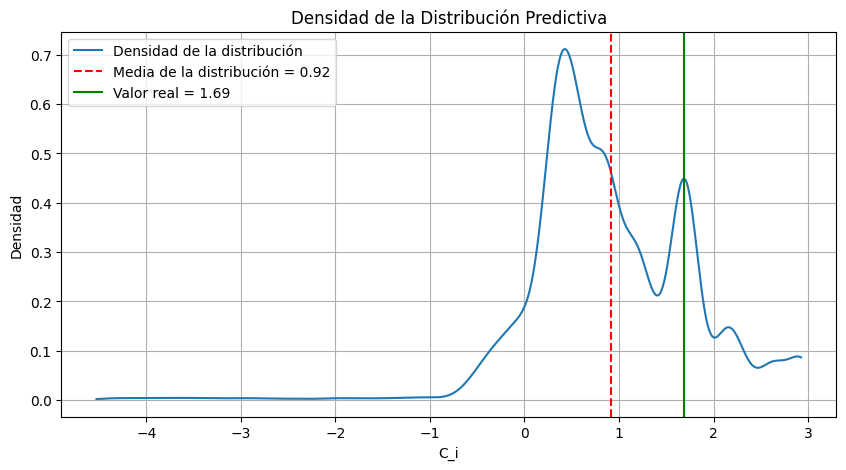

CRPS: 0.4953


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.linalg import solve
from scipy.stats import gaussian_kde
from properscoring import crps_ensemble
from numba import jit
import warnings
warnings.filterwarnings('ignore')

@jit(nopython=True)
def create_lag_matrix(values, n_lags):
    n = len(values) - n_lags
    X = np.zeros((n, n_lags + 1))
    X[:, 0] = 1  # Intercepto
    
    for lag in range(n_lags):
        X[:, lag + 1] = values[lag:lag + n]
    
    return X

def prepare_data(df, n_lags=5):
    values = df['valor'].values
    mean_val = np.mean(values)
    std_val = np.std(values)
    normalized_values = (values - mean_val) / std_val
    
    X = create_lag_matrix(normalized_values, n_lags)
    y = normalized_values[n_lags:]
    
    return X, y, mean_val, std_val

@jit(nopython=True)
def fast_hat_matrix(X):
    XtX = X.T @ X
    XtX_inv = np.linalg.inv(XtX)
    return X @ XtX_inv @ X.T

def calculate_C_values_optimized(X, y, x_test):
    n = len(y)
    X_bar = np.vstack((X, x_test))
    H_bar = fast_hat_matrix(X_bar)
    H = H_bar[:-1, :-1]
    h = H_bar[-1, :-1]
    
    I_minus_H_inv = solve(np.eye(n) - H, np.eye(n))
    y_minus_Hy = y - H @ y
    h_i_star = H - np.outer(np.ones(n), h)
    
    C = y + (h_i_star @ I_minus_H_inv) @ y_minus_Hy
    
    return C

def plot_predictive_distribution(C, y_real, num_points=1000):
    C_sorted = np.sort(C)
    y_range = np.linspace(C_sorted[0] - 0.5, C_sorted[-1] + 0.5, num_points)
    intervals = np.array([[max(0, np.sum(C_sorted <= y)/len(C_sorted) - 1), min(1, np.sum(C_sorted <= y)/len(C_sorted))] for y in y_range])
    
    lower_bounds, upper_bounds = intervals[:, 0], intervals[:, 1]
    mean_pred = (lower_bounds + upper_bounds) / 2
    weighted_mean = np.sum(y_range * mean_pred) / np.sum(mean_pred)
    
    plt.figure(figsize=(12, 6))
    plt.fill_between(y_range, lower_bounds, upper_bounds, alpha=0.3, color='blue', label='Distribución predictiva Q_n')
    plt.axvline(x=weighted_mean, color='r', linestyle='--', label=f'Media predictiva = {weighted_mean:.2f}')
    plt.axvline(x=y_real, color='g', linestyle='-', label=f'Valor real = {y_real:.2f}')
    plt.xlabel('y')
    plt.ylabel('Q_n(y)')
    plt.title('Distribución Predictiva Q_n')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_density_distribution(C, y_real):
    density = gaussian_kde(C)
    x_vals = np.linspace(min(C), max(C), 1000)
    y_vals = density(x_vals)
    mean_C = np.mean(C)
    
    plt.figure(figsize=(10, 5))
    plt.plot(x_vals, y_vals, label='Densidad de la distribución')
    plt.axvline(mean_C, color='r', linestyle='--', label=f'Media de la distribución = {mean_C:.2f}')
    plt.axvline(y_real, color='g', linestyle='-', label=f'Valor real = {y_real:.2f}')
    plt.xlabel('C_i')
    plt.ylabel('Densidad')
    plt.title('Densidad de la Distribución Predictiva')
    plt.legend()
    plt.grid(True)
    plt.show()
    

def plot_time_series(df):
    plt.figure(figsize=(12, 6))
    plt.plot(df['fecha'], df['valor'], alpha=0.7, linewidth=1)
    plt.xlabel('Fecha')
    plt.ylabel('Valor')
    plt.title('Serie Temporal Original')
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def apply_weights_efficient(C, rho, max_points):
    n = len(C)
    weights = rho ** np.arange(n-1, -1, -1)
    weights = weights / np.min(weights)
    
    scale_factor = min(max_points / np.sum(weights), 100)
    repeats = np.maximum(np.round(weights * scale_factor).astype(np.int64), 1)
    
    total_points = np.sum(repeats)
    result = np.zeros(total_points)
    
    current_idx = 0
    for i in range(n):
        result[current_idx:current_idx + repeats[i]] = C[i]
        current_idx += repeats[i]
    
    return result

def main():
    df = pd.read_csv("../../data/IPG2211A2N.csv", usecols=['DATE', 'IPG2211A2N'], nrows=300, parse_dates=['DATE'])
    df = df.rename(columns={'DATE': 'fecha', 'IPG2211A2N': 'valor'})
    df = df.dropna(subset=['valor']).reset_index(drop=True)
    df['fecha'] = pd.date_range(start=df['fecha'].min(), periods=len(df), freq='MS')
    
    plot_time_series(df)
    
    n_lags = 5
    X, y, mean_val, std_val = prepare_data(df, n_lags)
    last_values = (df['valor'].iloc[-n_lags-1:-1].values - mean_val) / std_val
    x_test = np.concatenate(([1], last_values[::-1]))
    y_real = (df['valor'].iloc[-1] - mean_val) / std_val
    
    C = calculate_C_values_optimized(X, y, x_test)
    C_weighted = apply_weights_efficient(C, rho=0.95, max_points=10000)
    
    plot_predictive_distribution(C_weighted, y_real)
    plot_density_distribution(C_weighted, y_real)
    
    sample_size = min(1000, len(C_weighted))
    C_sample = C_weighted[np.random.choice(len(C_weighted), sample_size, replace=False)]
    C_sorted = np.sort(C_sample)
    crps = crps_ensemble(np.array([y_real]), C_sorted.reshape(1, -1))[0]
    print(f"CRPS: {crps:.4f}")
    
    return crps

if __name__ == "__main__":
    main()


# Comparación